# LME銅先物 隣月間スプレッド 基本分析

## 概要
このノートブックでは、LME銅先物の隣月間スプレッド（M1-M2、M2-M3、M3-M4）の基本分析を行います。

### 分析対象
- **M1-M2スプレッド**: 第1限月 - 第2限月
- **M2-M3スプレッド**: 第2限月 - 第3限月  
- **M3-M4スプレッド**: 第3限月 - 第4限月

### 期待される成果
- 隣月間スプレッドの基本統計量と分布特性
- 各スプレッドの時系列推移とトレンド
- スプレッド水準の季節性とパターン
- リスク特性とボラティリティ分析

In [80]:
# 必要ライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
from sqlalchemy import create_engine
import warnings
from datetime import datetime, timedelta
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from scipy import stats
import os

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [81]:
# データベース接続設定
def get_db_connection():
    """PostgreSQLデータベースへの接続を取得"""
    try:
        engine = create_engine('postgresql://Yusuke@localhost:5432/lme_copper_db')
        return engine
    except Exception as e:
        print(f"データベース接続エラー: {e}")
        return None

# データベース接続テスト
engine = get_db_connection()
if engine:
    print("✅ データベース接続成功")
else:
    print("❌ データベース接続失敗")

✅ データベース接続成功


## 1. データ取得と前処理

In [82]:
def load_futures_data():
    """先物データの取得"""
    query = """
    SELECT 
        trade_date,
        contract_month,
        close_price,
        volume,
        open_interest,
        ric
    FROM lme_copper_futures 
    WHERE contract_month IN (1, 2, 3, 4)
        AND close_price IS NOT NULL
        AND close_price > 0
    ORDER BY trade_date, contract_month
    """
    
    df = pd.read_sql(query, engine)
    df['trade_date'] = pd.to_datetime(df['trade_date'])
    
    print(f"📊 データ取得完了:")
    print(f"   総レコード数: {len(df):,}")
    print(f"   データ期間: {df['trade_date'].min()} ～ {df['trade_date'].max()}")
    print(f"   限月別レコード数:")
    for month in [1, 2, 3, 4]:
        count = len(df[df['contract_month'] == month])
        print(f"     M{month}: {count:,} レコード")
    
    return df

# データ取得
futures_data = load_futures_data()

📊 データ取得完了:
   総レコード数: 4,991
   データ期間: 2020-07-06 00:00:00 ～ 2025-07-04 00:00:00
   限月別レコード数:
     M1: 1,202 レコード
     M2: 1,263 レコード
     M3: 1,263 レコード
     M4: 1,263 レコード


In [83]:
def calculate_adjacent_spreads(df):
    """隣月間スプレッドの計算"""
    # データをピボットして限月別カラムに変換
    pivot_df = df.pivot(index='trade_date', columns='contract_month', values='close_price')
    
    # カラム名を分かりやすく変更
    pivot_df.columns = [f'M{int(col)}' for col in pivot_df.columns]
    
    # 隣月間スプレッドを計算
    spreads_df = pd.DataFrame(index=pivot_df.index)
    
    spreads_df['M1_price'] = pivot_df['M1']
    spreads_df['M2_price'] = pivot_df['M2']
    spreads_df['M3_price'] = pivot_df['M3']
    spreads_df['M4_price'] = pivot_df['M4']
    
    # スプレッドの計算（前限月 - 後限月）
    spreads_df['M1_M2_spread'] = pivot_df['M1'] - pivot_df['M2']
    spreads_df['M2_M3_spread'] = pivot_df['M2'] - pivot_df['M3']
    spreads_df['M3_M4_spread'] = pivot_df['M3'] - pivot_df['M4']
    
    # スプレッド変化率（日次リターン）
    spreads_df['M1_M2_spread_change'] = spreads_df['M1_M2_spread'].pct_change()
    spreads_df['M2_M3_spread_change'] = spreads_df['M2_M3_spread'].pct_change()
    spreads_df['M3_M4_spread_change'] = spreads_df['M3_M4_spread'].pct_change()
    
    # NaN値を除去
    spreads_df = spreads_df.dropna()
    
    print(f"📈 スプレッド計算完了:")
    print(f"   有効データ数: {len(spreads_df):,}")
    print(f"   欠損値除去後期間: {spreads_df.index.min()} ～ {spreads_df.index.max()}")
    
    return spreads_df

# スプレッド計算
spreads_data = calculate_adjacent_spreads(futures_data)

# データの先頭確認
print("\n📋 計算されたスプレッドデータ（直近5日分）:")
print(spreads_data.tail())

📈 スプレッド計算完了:
   有効データ数: 1,198
   欠損値除去後期間: 2020-07-07 00:00:00 ～ 2025-07-04 00:00:00

📋 計算されたスプレッドデータ（直近5日分）:
            M1_price  M2_price  M3_price  M4_price  M1_M2_spread  \
trade_date                                                         
2025-06-30   9945.23   9906.38   9882.68   9865.44         38.85   
2025-07-01   9997.29   9962.55   9945.03   9930.09         34.74   
2025-07-02  10070.10  10038.46  10023.00  10009.82         31.64   
2025-07-03  10010.67   9977.38   9963.00   9951.31         33.29   
2025-07-04   9923.29   9887.30   9873.62   9861.73         35.99   

            M2_M3_spread  M3_M4_spread  M1_M2_spread_change  \
trade_date                                                    
2025-06-30         23.70         17.24            -0.028507   
2025-07-01         17.52         14.94            -0.105792   
2025-07-02         15.46         13.18            -0.089234   
2025-07-03         14.38         11.69             0.052149   
2025-07-04         13.68         11

## 2. 基本統計量とデータ概要

In [84]:
def calculate_basic_statistics(df):
    """基本統計量の計算"""
    spread_columns = ['M1_M2_spread', 'M2_M3_spread', 'M3_M4_spread']
    
    stats_df = pd.DataFrame()
    
    for col in spread_columns:
        spread_name = col.replace('_spread', '').replace('_', '-')
        
        stats_df[spread_name] = [
            df[col].count(),           # 有効データ数
            df[col].mean(),            # 平均
            df[col].median(),          # 中央値
            df[col].std(),             # 標準偏差
            df[col].min(),             # 最小値
            df[col].max(),             # 最大値
            df[col].quantile(0.25),    # 第1四分位数
            df[col].quantile(0.75),    # 第3四分位数
            df[col].skew(),            # 歪度
            df[col].kurtosis(),        # 尖度
        ]
    
    stats_df.index = ['データ数', '平均', '中央値', '標準偏差', '最小値', '最大値', 
                      'Q1(25%)', 'Q3(75%)', '歪度', '尖度']
    
    return stats_df

# 基本統計量を計算
basic_stats = calculate_basic_statistics(spreads_data)

print("📊 隣月間スプレッド基本統計量:")
print("=" * 50)
print(basic_stats.round(4))

📊 隣月間スプレッド基本統計量:
             M1-M2      M2-M3      M3-M4
データ数     1198.0000  1198.0000  1198.0000
平均         -7.3683    -6.4624    -5.8316
中央値        -5.0000    -3.1800    -2.2500
標準偏差       42.9368    21.8381    18.2204
最小値       -68.7900   -55.4400   -48.9200
最大値      1060.0000   106.0000    42.0000
Q1(25%)   -30.8750   -21.9375   -18.7575
Q3(75%)     4.0000     3.0000     3.5000
歪度         13.5506     0.1747    -0.3792
尖度        321.5406     0.7680    -0.2836


In [85]:
# スプレッドの分布特性を詳細分析
def analyze_spread_characteristics(df):
    """スプレッド特性の詳細分析"""
    spread_columns = ['M1_M2_spread', 'M2_M3_spread', 'M3_M4_spread']
    
    print("\n🔍 隣月間スプレッド特性分析:")
    print("=" * 60)
    
    for col in spread_columns:
        spread_name = col.replace('_spread', '').replace('_', '-')
        data = df[col]
        
        # 正値・負値の分布
        positive_ratio = (data > 0).mean() * 100
        negative_ratio = (data < 0).mean() * 100
        zero_ratio = (data == 0).mean() * 100
        
        # 極値の頻度
        q95 = data.quantile(0.95)
        q05 = data.quantile(0.05)
        extreme_high = (data > q95).sum()
        extreme_low = (data < q05).sum()
        
        print(f"\n{spread_name}スプレッド:")
        print(f"  正値（コンタンゴ）: {positive_ratio:.1f}%")
        print(f"  負値（バックワーデーション）: {negative_ratio:.1f}%")
        print(f"  ゼロ（フラット）: {zero_ratio:.1f}%")
        print(f"  95%分位点超過: {extreme_high}回 ({extreme_high/len(data)*100:.1f}%)")
        print(f"  5%分位点未満: {extreme_low}回 ({extreme_low/len(data)*100:.1f}%)")
        print(f"  変動幅（Max-Min）: {data.max() - data.min():.2f} USD/t")

analyze_spread_characteristics(spreads_data)


🔍 隣月間スプレッド特性分析:

M1-M2スプレッド:
  正値（コンタンゴ）: 36.7%
  負値（バックワーデーション）: 62.4%
  ゼロ（フラット）: 0.9%
  95%分位点超過: 60回 (5.0%)
  5%分位点未満: 60回 (5.0%)
  変動幅（Max-Min）: 1128.79 USD/t

M2-M3スプレッド:
  正値（コンタンゴ）: 36.6%
  負値（バックワーデーション）: 61.7%
  ゼロ（フラット）: 1.8%
  95%分位点超過: 60回 (5.0%)
  5%分位点未満: 60回 (5.0%)
  変動幅（Max-Min）: 161.44 USD/t

M3-M4スプレッド:
  正値（コンタンゴ）: 40.4%
  負値（バックワーデーション）: 58.6%
  ゼロ（フラット）: 1.0%
  95%分位点超過: 60回 (5.0%)
  5%分位点未満: 60回 (5.0%)
  変動幅（Max-Min）: 90.92 USD/t


## 3. 時系列推移とトレンド分析

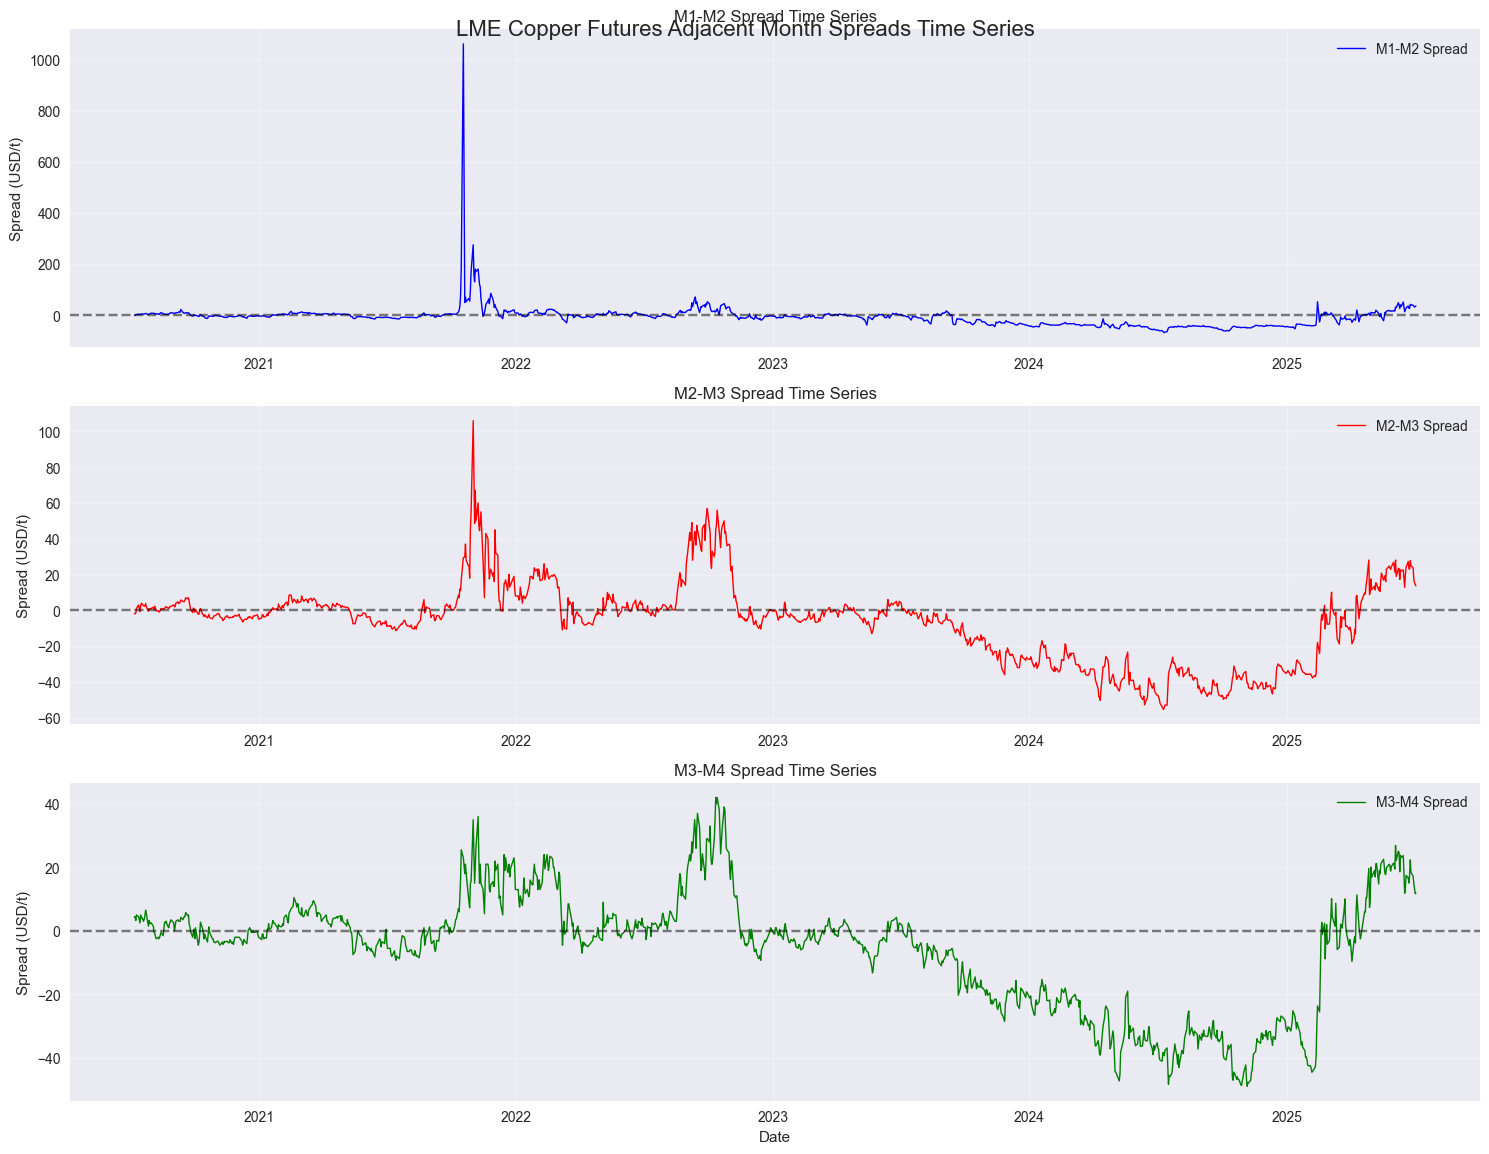

In [86]:
# 隣月間スプレッドの時系列チャート
def plot_spread_timeseries(df):
    """隣月間スプレッドの時系列チャート（matplotlib版）"""
    fig, axes = plt.subplots(3, 1, figsize=(15, 12))
    
    spreads = [
        ('M1_M2_spread', 'M1-M2', 'blue'),
        ('M2_M3_spread', 'M2-M3', 'red'),
        ('M3_M4_spread', 'M3-M4', 'green')
    ]
    
    for i, (col, name, color) in enumerate(spreads):
        axes[i].plot(df.index, df[col], color=color, linewidth=1, label=f"{name} Spread")
        axes[i].axhline(y=0, color='black', linestyle='--', alpha=0.5)
        axes[i].set_title(f'{name} Spread Time Series')
        axes[i].set_ylabel('Spread (USD/t)')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
    
    axes[-1].set_xlabel('Date')
    plt.suptitle('LME Copper Futures Adjacent Month Spreads Time Series', fontsize=16, y=0.95)
    plt.tight_layout()
    
    return fig

# チャート表示
spread_chart = plot_spread_timeseries(spreads_data)
plt.show()

# 画像保存
os.makedirs('../../generated_images', exist_ok=True)
spread_chart.savefig('../../generated_images/adjacent_spreads_timeseries.png', 
                    dpi=300, bbox_inches='tight')

In [87]:
# スプレッドの移動平均とトレンド分析
def calculate_trend_analysis(df):
    """トレンド分析とテクニカル指標"""
    spread_columns = ['M1_M2_spread', 'M2_M3_spread', 'M3_M4_spread']
    
    trend_df = df.copy()
    
    for col in spread_columns:
        # 移動平均
        trend_df[f'{col}_ma5'] = df[col].rolling(window=5).mean()
        trend_df[f'{col}_ma20'] = df[col].rolling(window=20).mean()
        trend_df[f'{col}_ma60'] = df[col].rolling(window=60).mean()
        
        # ボリンジャーバンド（20日、2σ）
        ma20 = trend_df[f'{col}_ma20']
        std20 = df[col].rolling(window=20).std()
        trend_df[f'{col}_bb_upper'] = ma20 + (std20 * 2)
        trend_df[f'{col}_bb_lower'] = ma20 - (std20 * 2)
        
        # RSI（14日）
        delta = df[col].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss
        trend_df[f'{col}_rsi'] = 100 - (100 / (1 + rs))
    
    return trend_df

# トレンド分析実行
trend_data = calculate_trend_analysis(spreads_data)

print("📈 トレンド分析指標を計算しました:")
print(f"   移動平均: 5日、20日、60日")
print(f"   ボリンジャーバンド: 20日±2σ")
print(f"   RSI: 14日")

📈 トレンド分析指標を計算しました:
   移動平均: 5日、20日、60日
   ボリンジャーバンド: 20日±2σ
   RSI: 14日


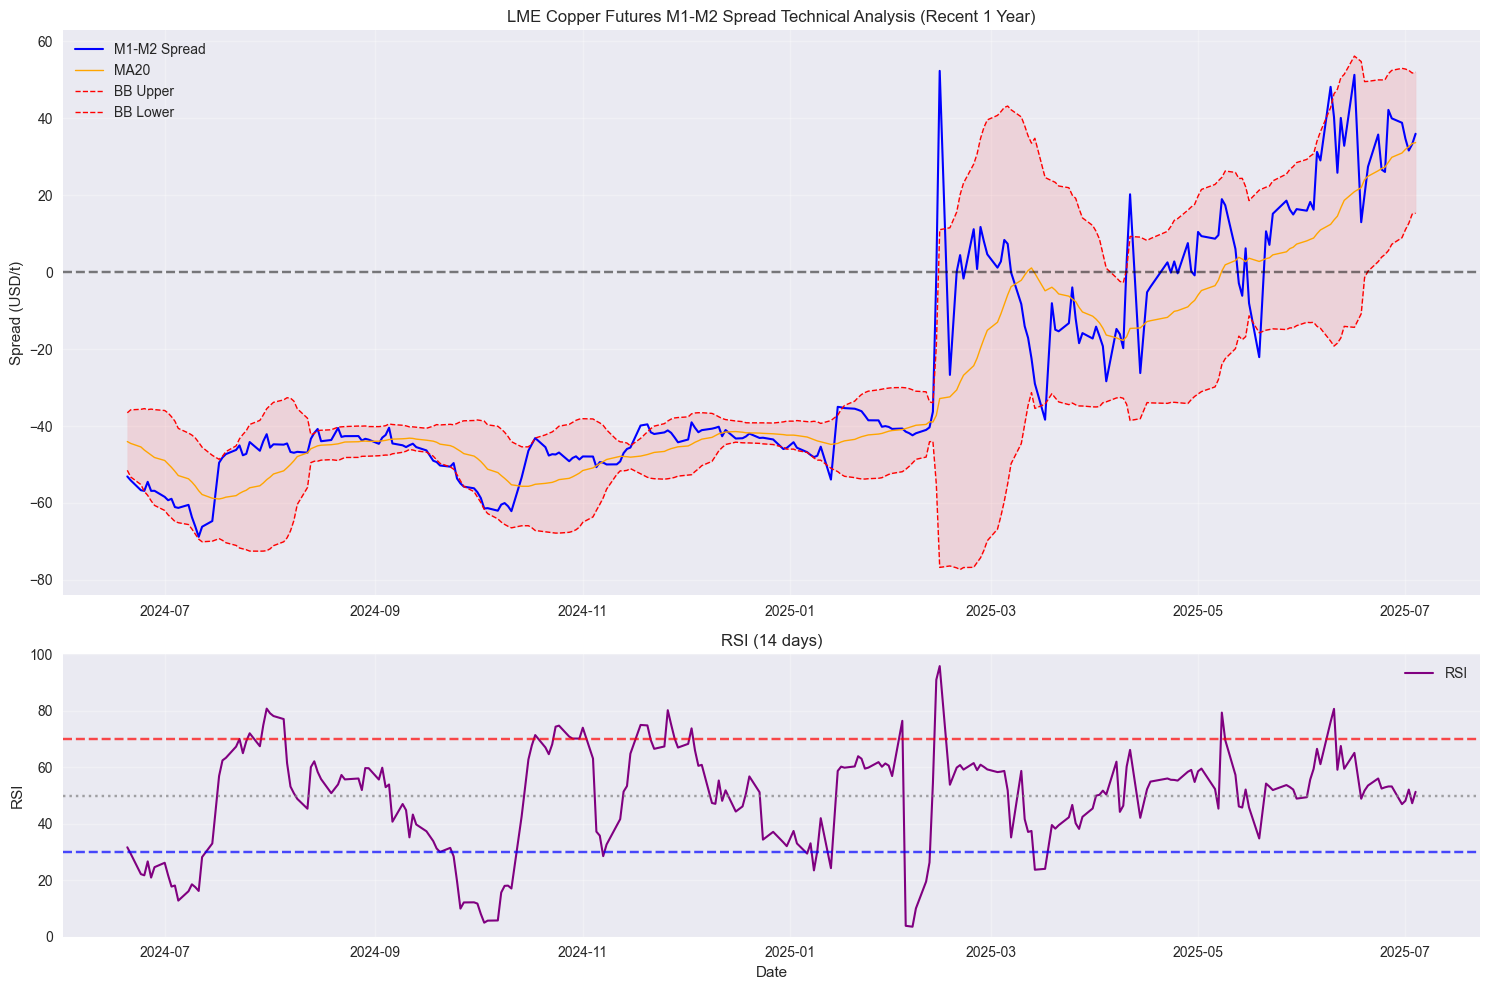

In [88]:
# M1-M2スプレッドのテクニカル分析チャート
def plot_technical_analysis(df, spread_col='M1_M2_spread', title='M1-M2'):
    """テクニカル分析チャート（matplotlib版）"""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), height_ratios=[2, 1])
    
    # 直近1年分のデータ
    recent_data = df.iloc[-252:] if len(df) > 252 else df
    
    # メインチャート（スプレッド + 移動平均 + ボリンジャーバンド）
    ax1.plot(recent_data.index, recent_data[spread_col], 
             label=f'{title} Spread', color='blue', linewidth=1.5)
    ax1.plot(recent_data.index, recent_data[f'{spread_col}_ma20'], 
             label='MA20', color='orange', linewidth=1)
    
    # ボリンジャーバンド
    ax1.plot(recent_data.index, recent_data[f'{spread_col}_bb_upper'], 
             label='BB Upper', color='red', linewidth=1, linestyle='--')
    ax1.plot(recent_data.index, recent_data[f'{spread_col}_bb_lower'], 
             label='BB Lower', color='red', linewidth=1, linestyle='--')
    ax1.fill_between(recent_data.index, 
                     recent_data[f'{spread_col}_bb_upper'], 
                     recent_data[f'{spread_col}_bb_lower'], 
                     alpha=0.1, color='red')
    
    # ゼロライン
    ax1.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    
    ax1.set_title(f'LME Copper Futures {title} Spread Technical Analysis (Recent 1 Year)')
    ax1.set_ylabel('Spread (USD/t)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # RSI
    ax2.plot(recent_data.index, recent_data[f'{spread_col}_rsi'], 
             color='purple', linewidth=1.5, label='RSI')
    ax2.axhline(y=70, color='red', linestyle='--', alpha=0.7)
    ax2.axhline(y=30, color='blue', linestyle='--', alpha=0.7)
    ax2.axhline(y=50, color='gray', linestyle=':', alpha=0.7)
    
    ax2.set_title('RSI (14 days)')
    ax2.set_ylabel('RSI')
    ax2.set_xlabel('Date')
    ax2.set_ylim(0, 100)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

# M1-M2スプレッドのテクニカル分析
tech_chart = plot_technical_analysis(trend_data, 'M1_M2_spread', 'M1-M2')
plt.show()

# 画像保存
tech_chart.savefig('../../generated_images/m1_m2_spread_technical_analysis.png', 
                  dpi=300, bbox_inches='tight')

## 4. スプレッド分布とリスク分析

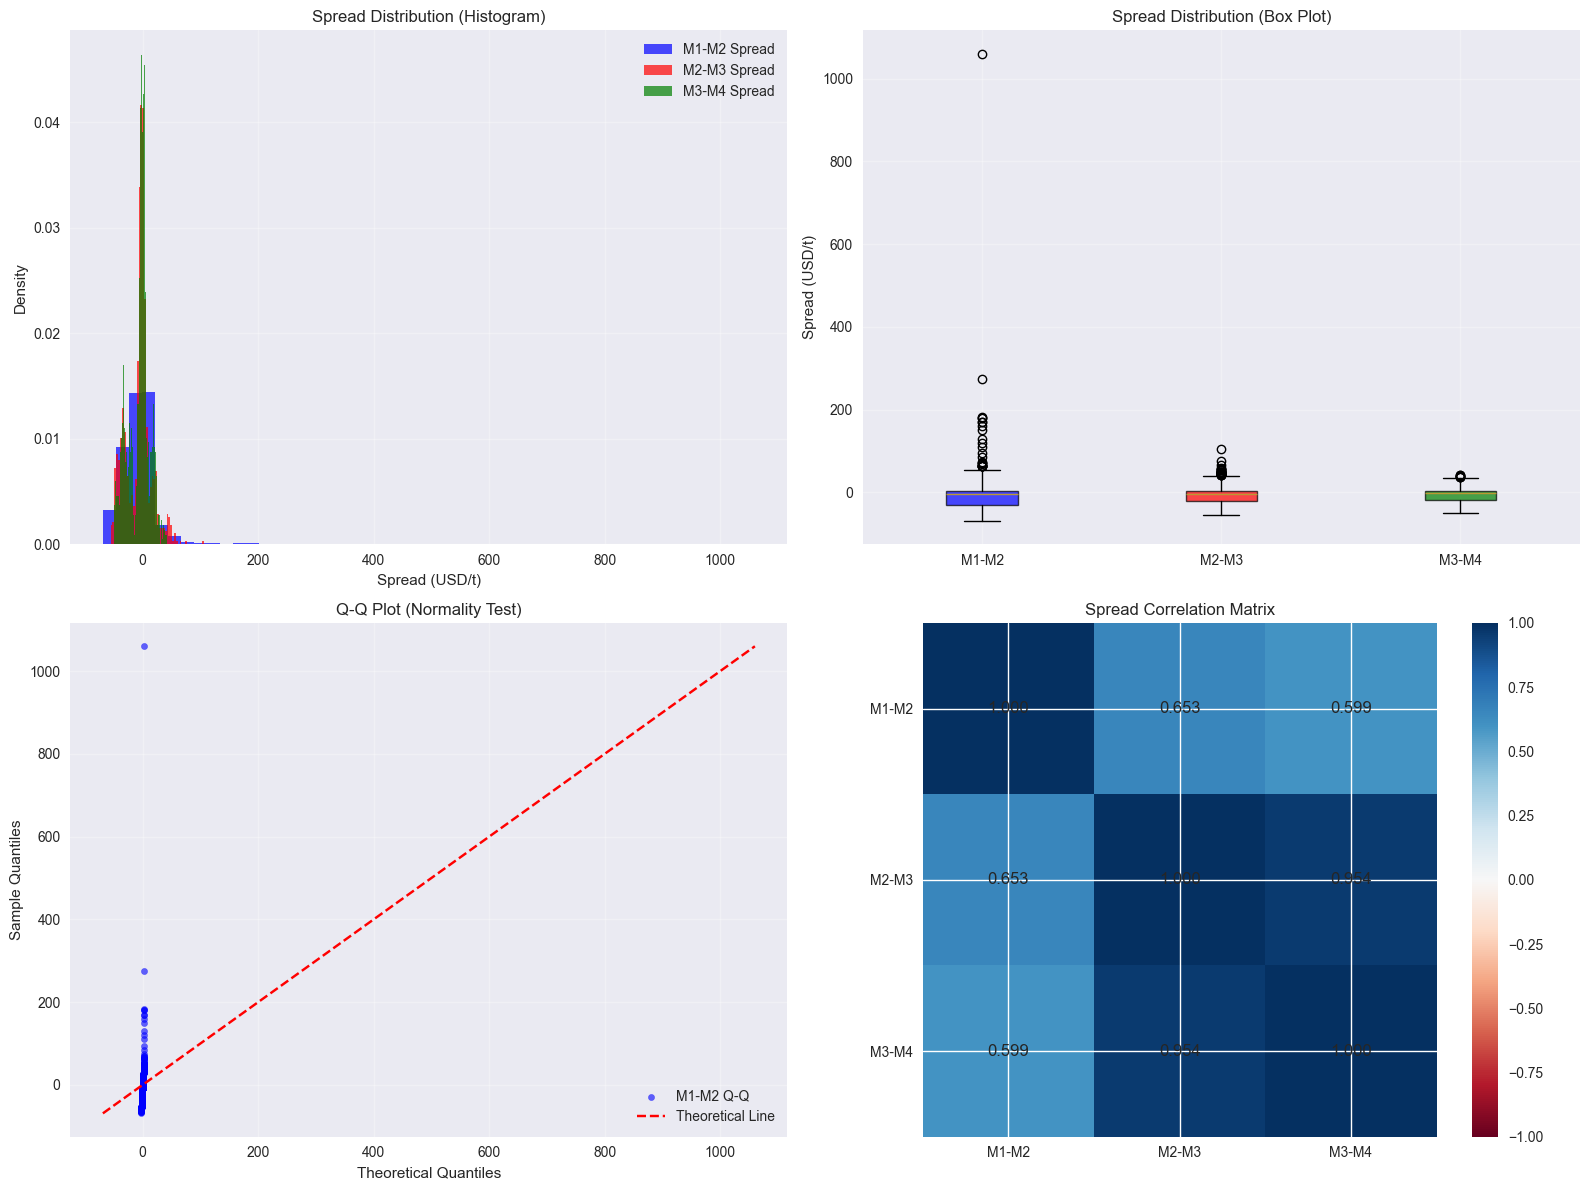

In [89]:
# スプレッド分布の詳細分析
def plot_spread_distributions(df):
    """スプレッド分布の可視化（matplotlib版）"""
    spread_columns = ['M1_M2_spread', 'M2_M3_spread', 'M3_M4_spread']
    spread_names = ['M1-M2', 'M2-M3', 'M3-M4']
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    colors = ['blue', 'red', 'green']
    
    # 1. ヒストグラム
    for i, (col, name, color) in enumerate(zip(spread_columns, spread_names, colors)):
        ax1.hist(df[col], bins=50, alpha=0.7, color=color, label=f'{name} Spread', density=True)
    ax1.set_title('Spread Distribution (Histogram)')
    ax1.set_xlabel('Spread (USD/t)')
    ax1.set_ylabel('Density')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. ボックスプロット
    box_data = [df[col].dropna() for col in spread_columns]
    bp = ax2.boxplot(box_data, labels=spread_names, patch_artist=True)
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    ax2.set_title('Spread Distribution (Box Plot)')
    ax2.set_ylabel('Spread (USD/t)')
    ax2.grid(True, alpha=0.3)
    
    # 3. Q-Qプロット（M1-M2スプレッドのみ）
    from scipy.stats import probplot
    
    # データを清理してNaNを除去
    clean_data = df['M1_M2_spread'].dropna()
    
    # probplotの正しい使用方法
    prob_result = probplot(clean_data, dist="norm", plot=None)
    theoretical_quantiles = prob_result[0][0]
    sample_quantiles = prob_result[0][1]
    
    ax3.scatter(theoretical_quantiles, sample_quantiles, alpha=0.6, s=20, color='blue', label='M1-M2 Q-Q')
    
    # 理論線の計算
    min_val = min(theoretical_quantiles.min(), sample_quantiles.min())
    max_val = max(theoretical_quantiles.max(), sample_quantiles.max())
    ax3.plot([min_val, max_val], [min_val, max_val], 'r--', label='Theoretical Line')
    
    ax3.set_title('Q-Q Plot (Normality Test)')
    ax3.set_xlabel('Theoretical Quantiles')
    ax3.set_ylabel('Sample Quantiles')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. 相関行列のヒートマップ
    corr_matrix = df[spread_columns].corr()
    im = ax4.imshow(corr_matrix, cmap='RdBu', vmin=-1, vmax=1)
    
    # 相関係数の値を表示
    for i in range(len(spread_names)):
        for j in range(len(spread_names)):
            ax4.text(j, i, f'{corr_matrix.iloc[i, j]:.3f}', 
                    ha='center', va='center', fontsize=12)
    
    ax4.set_xticks(range(len(spread_names)))
    ax4.set_yticks(range(len(spread_names)))
    ax4.set_xticklabels(spread_names)
    ax4.set_yticklabels(spread_names)
    ax4.set_title('Spread Correlation Matrix')
    
    # カラーバー
    plt.colorbar(im, ax=ax4)
    
    plt.tight_layout()
    return fig

# 分布分析チャート
dist_chart = plot_spread_distributions(spreads_data)
plt.show()

# 画像保存
dist_chart.savefig('../../generated_images/adjacent_spreads_distribution_analysis.png', 
                  dpi=300, bbox_inches='tight')

In [90]:
# 正規性検定と統計的検定
def statistical_tests(df):
    """統計的検定の実行"""
    spread_columns = ['M1_M2_spread', 'M2_M3_spread', 'M3_M4_spread']
    spread_names = ['M1-M2', 'M2-M3', 'M3-M4']
    
    print("🔬 統計的検定結果:")
    print("=" * 60)
    
    test_results = {}
    
    for col, name in zip(spread_columns, spread_names):
        data = df[col].dropna()
        
        # Shapiro-Wilk正規性検定
        if len(data) <= 5000:  # サンプル数制限
            shapiro_stat, shapiro_p = stats.shapiro(data)
        else:
            shapiro_stat, shapiro_p = stats.shapiro(data.sample(5000))
        
        # Jarque-Bera正規性検定
        jb_stat, jb_p = stats.jarque_bera(data)
        
        # Kolmogorov-Smirnov正規性検定
        ks_stat, ks_p = stats.kstest(data, 'norm', args=(data.mean(), data.std()))
        
        # Augmented Dickey-Fuller単位根検定（定常性）
        from statsmodels.tsa.stattools import adfuller
        adf_result = adfuller(data)
        
        test_results[name] = {
            'shapiro': (shapiro_stat, shapiro_p),
            'jarque_bera': (jb_stat, jb_p),
            'ks_test': (ks_stat, ks_p),
            'adf': adf_result
        }
        
        print(f"\n{name}スプレッド:")
        print(f"  Shapiro-Wilk正規性検定: 統計量={shapiro_stat:.4f}, p値={shapiro_p:.4f}")
        print(f"  Jarque-Bera正規性検定: 統計量={jb_stat:.4f}, p値={jb_p:.4f}")
        print(f"  K-S正規性検定: 統計量={ks_stat:.4f}, p値={ks_p:.4f}")
        print(f"  ADF単位根検定: 統計量={adf_result[0]:.4f}, p値={adf_result[1]:.4f}")
        
        # 解釈
        normal_tests = [shapiro_p, jb_p, ks_p]
        if all(p < 0.05 for p in normal_tests):
            print(f"  → 正規分布ではない（全検定でp<0.05）")
        elif any(p >= 0.05 for p in normal_tests):
            print(f"  → 正規分布の可能性あり（一部検定でp≥0.05）")
        
        if adf_result[1] < 0.05:
            print(f"  → 定常系列（ADF検定p<0.05）")
        else:
            print(f"  → 非定常系列の可能性（ADF検定p≥0.05）")
    
    return test_results

# 統計的検定実行
test_results = statistical_tests(spreads_data)

🔬 統計的検定結果:

M1-M2スプレッド:
  Shapiro-Wilk正規性検定: 統計量=0.4934, p値=0.0000
  Jarque-Bera正規性検定: 統計量=5154274.7456, p値=0.0000
  K-S正規性検定: 統計量=0.2099, p値=0.0000
  ADF単位根検定: 統計量=-3.6510, p値=0.0049
  → 正規分布ではない（全検定でp<0.05）
  → 定常系列（ADF検定p<0.05）

M2-M3スプレッド:
  Shapiro-Wilk正規性検定: 統計量=0.9503, p値=0.0000
  Jarque-Bera正規性検定: 統計量=34.8976, p値=0.0000
  K-S正規性検定: 統計量=0.1399, p値=0.0000
  ADF単位根検定: 統計量=-2.1059, p値=0.2421
  → 正規分布ではない（全検定でp<0.05）
  → 非定常系列の可能性（ADF検定p≥0.05）

M3-M4スプレッド:
  Shapiro-Wilk正規性検定: 統計量=0.9541, p値=0.0000
  Jarque-Bera正規性検定: 統計量=32.7679, p値=0.0000
  K-S正規性検定: 統計量=0.1557, p値=0.0000
  ADF単位根検定: 統計量=-1.9841, p値=0.2936
  → 正規分布ではない（全検定でp<0.05）
  → 非定常系列の可能性（ADF検定p≥0.05）


## 5. 季節性とパターン分析

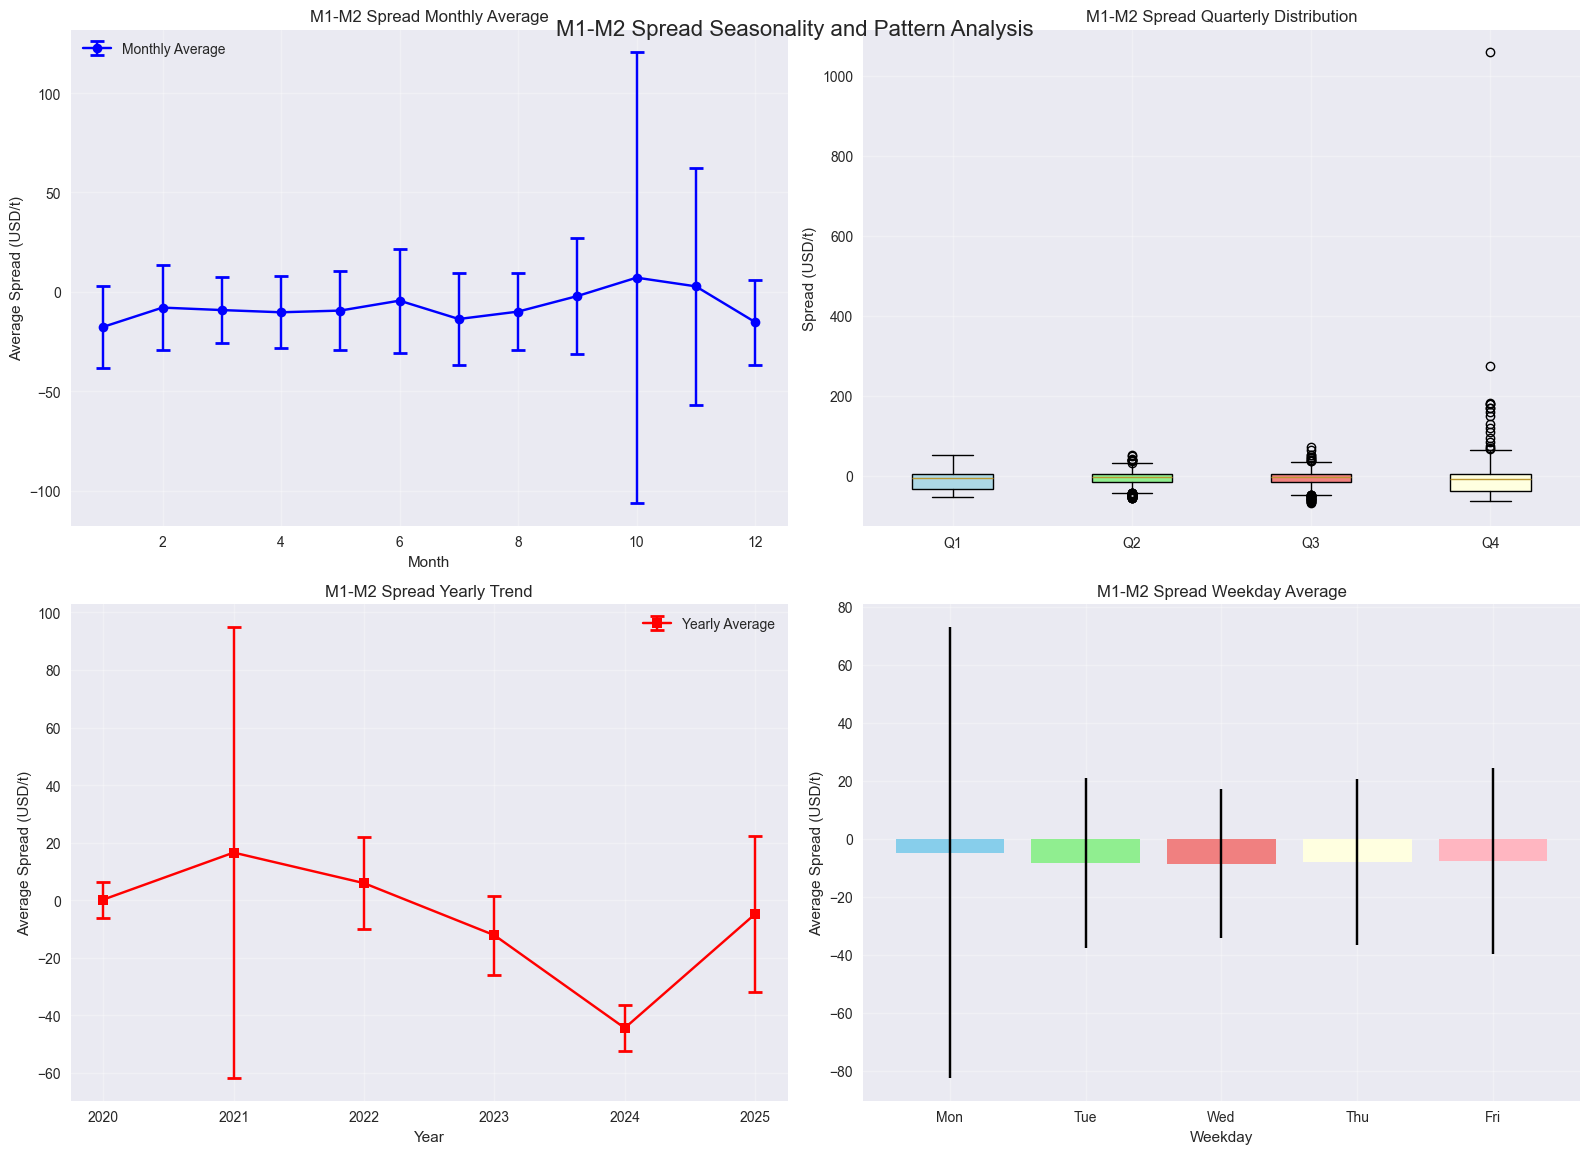

In [91]:
# 季節性分析
def analyze_seasonality(df):
    """季節性とパターン分析"""
    seasonal_df = df.copy()
    
    # 時間的特徴量を追加
    seasonal_df['year'] = seasonal_df.index.year
    seasonal_df['month'] = seasonal_df.index.month
    seasonal_df['quarter'] = seasonal_df.index.quarter
    seasonal_df['day_of_year'] = seasonal_df.index.dayofyear
    seasonal_df['weekday'] = seasonal_df.index.weekday
    
    return seasonal_df

def plot_seasonality_analysis(df):
    """季節性分析チャート（matplotlib版）"""
    seasonal_data = analyze_seasonality(df)
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. 月別平均
    monthly_avg = seasonal_data.groupby('month')['M1_M2_spread'].agg(['mean', 'std']).reset_index()
    
    ax1.errorbar(monthly_avg['month'], monthly_avg['mean'], 
                yerr=monthly_avg['std'], 
                marker='o', capsize=5, capthick=2, color='blue', label='Monthly Average')
    ax1.set_title('M1-M2 Spread Monthly Average')
    ax1.set_xlabel('Month')
    ax1.set_ylabel('Average Spread (USD/t)')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # 2. 四半期別ボックスプロット
    quarterly_data = []
    quarter_labels = []
    for quarter in [1, 2, 3, 4]:
        quarter_data = seasonal_data[seasonal_data['quarter'] == quarter]['M1_M2_spread']
        quarterly_data.append(quarter_data)
        quarter_labels.append(f'Q{quarter}')
    
    bp = ax2.boxplot(quarterly_data, labels=quarter_labels, patch_artist=True)
    colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    ax2.set_title('M1-M2 Spread Quarterly Distribution')
    ax2.set_ylabel('Spread (USD/t)')
    ax2.grid(True, alpha=0.3)
    
    # 3. 年別平均推移
    yearly_avg = seasonal_data.groupby('year')['M1_M2_spread'].agg(['mean', 'std']).reset_index()
    
    ax3.errorbar(yearly_avg['year'], yearly_avg['mean'], 
                yerr=yearly_avg['std'], 
                marker='s', capsize=5, capthick=2, color='red', label='Yearly Average')
    ax3.set_title('M1-M2 Spread Yearly Trend')
    ax3.set_xlabel('Year')
    ax3.set_ylabel('Average Spread (USD/t)')
    ax3.grid(True, alpha=0.3)
    ax3.legend()
    
    # 4. 曜日別分析（修正版）
    weekday_avg = seasonal_data.groupby('weekday')['M1_M2_spread'].agg(['mean', 'std']).reset_index()
    
    # 実際に存在する曜日のみを使用
    weekday_names_full = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    available_weekdays = weekday_avg['weekday'].tolist()
    weekday_names = [weekday_names_full[i] for i in available_weekdays]
    
    # カラーも実際の曜日数に合わせる
    full_colors = ['skyblue', 'lightgreen', 'lightcoral', 'lightyellow', 
                   'lightpink', 'lightgray', 'lightsteelblue']
    weekday_colors = [full_colors[i] for i in available_weekdays]
    
    bars = ax4.bar(range(len(weekday_names)), weekday_avg['mean'], 
                   yerr=weekday_avg['std'], capsize=5, 
                   color=weekday_colors)
    
    ax4.set_title('M1-M2 Spread Weekday Average')
    ax4.set_xlabel('Weekday')
    ax4.set_ylabel('Average Spread (USD/t)')
    ax4.set_xticks(range(len(weekday_names)))
    ax4.set_xticklabels(weekday_names)
    ax4.grid(True, alpha=0.3)
    
    plt.suptitle('M1-M2 Spread Seasonality and Pattern Analysis', fontsize=16, y=0.95)
    plt.tight_layout()
    
    return fig, seasonal_data

# 季節性分析実行
seasonality_chart, seasonal_data = plot_seasonality_analysis(spreads_data)
plt.show()

# 画像保存
seasonality_chart.savefig('../../generated_images/adjacent_spreads_seasonality_analysis.png', 
                         dpi=300, bbox_inches='tight')

In [92]:
# 季節性の統計的有意性検定
def test_seasonality_significance(seasonal_data):
    """季節性の統計的有意性を検定"""
    print("🗓️ 季節性統計的検定:")
    print("=" * 50)
    
    # ANOVA検定（月別グループ間差異）
    monthly_groups = [seasonal_data[seasonal_data['month'] == i]['M1_M2_spread'].dropna() 
                     for i in range(1, 13)]
    
    f_stat, p_value = stats.f_oneway(*monthly_groups)
    print(f"月別ANOVA検定:")
    print(f"  F統計量: {f_stat:.4f}")
    print(f"  p値: {p_value:.4f}")
    print(f"  結果: {'月別に有意差あり' if p_value < 0.05 else '月別に有意差なし'}")
    
    # 四半期別ANOVA検定
    quarterly_groups = [seasonal_data[seasonal_data['quarter'] == i]['M1_M2_spread'].dropna() 
                       for i in range(1, 5)]
    
    f_stat_q, p_value_q = stats.f_oneway(*quarterly_groups)
    print(f"\n四半期別ANOVA検定:")
    print(f"  F統計量: {f_stat_q:.4f}")
    print(f"  p値: {p_value_q:.4f}")
    print(f"  結果: {'四半期別に有意差あり' if p_value_q < 0.05 else '四半期別に有意差なし'}")
    
    # 曜日別ANOVA検定
    weekday_groups = [seasonal_data[seasonal_data['weekday'] == i]['M1_M2_spread'].dropna() 
                     for i in range(7)]
    
    f_stat_w, p_value_w = stats.f_oneway(*weekday_groups)
    print(f"\n曜日別ANOVA検定:")
    print(f"  F統計量: {f_stat_w:.4f}")
    print(f"  p値: {p_value_w:.4f}")
    print(f"  結果: {'曜日別に有意差あり' if p_value_w < 0.05 else '曜日別に有意差なし'}")
    
    # 月別統計サマリー
    print(f"\n📈 月別統計サマリー:")
    monthly_stats = seasonal_data.groupby('month')['M1_M2_spread'].agg([
        'count', 'mean', 'std', 'min', 'max'
    ]).round(4)
    
    monthly_stats.index = [f'{i}月' for i in monthly_stats.index]
    print(monthly_stats)
    
    return {
        'monthly_anova': (f_stat, p_value),
        'quarterly_anova': (f_stat_q, p_value_q),
        'weekday_anova': (f_stat_w, p_value_w),
        'monthly_stats': monthly_stats
    }

# 季節性有意性検定実行
seasonality_tests = test_seasonality_significance(seasonal_data)

🗓️ 季節性統計的検定:
月別ANOVA検定:
  F統計量: 2.9448
  p値: 0.0007
  結果: 月別に有意差あり

四半期別ANOVA検定:
  F統計量: 3.0115
  p値: 0.0292
  結果: 四半期別に有意差あり

曜日別ANOVA検定:
  F統計量: nan
  p値: nan
  結果: 曜日別に有意差なし

📈 月別統計サマリー:
     count     mean       std    min      max
1月     100 -17.5934   20.4575 -53.91    20.00
2月      96  -7.9081   21.4817 -42.40    52.34
3月     105  -9.1451   16.6064 -42.00    13.00
4月      93 -10.2598   18.1166 -50.13    20.26
5月      95  -9.4047   19.6993 -53.27    18.99
6月     100  -4.4049   26.2189 -56.85    51.31
7月     105 -13.6442   23.3386 -68.79    35.99
8月     100  -9.9185   19.4565 -46.94    18.50
9月     103  -2.1018   29.2452 -56.18    71.00
10月    103   7.1570  113.4837 -62.12  1060.00
11月    103   2.7839   59.5398 -50.68   275.00
12月     95 -15.1921   21.3466 -45.97    41.00


## 6. 分析結果サマリーと洞察

In [93]:
# 包括的分析サマリー
def generate_analysis_summary(spreads_data, basic_stats, seasonality_tests):
    """包括的分析サマリーの生成"""
    
    print("📋 LME銅先物 隣月間スプレッド分析サマリー")
    print("=" * 70)
    
    print(f"\n🔢 データ概要:")
    print(f"  分析期間: {spreads_data.index.min().strftime('%Y-%m-%d')} ～ {spreads_data.index.max().strftime('%Y-%m-%d')}")
    print(f"  データポイント数: {len(spreads_data):,}")
    print(f"  分析対象: M1-M2, M2-M3, M3-M4 隣月間スプレッド")
    
    print(f"\n📊 基本統計特性:")
    for col in ['M1-M2', 'M2-M3', 'M3-M4']:
        mean_val = basic_stats.loc['平均', col]
        std_val = basic_stats.loc['標準偏差', col]
        skew_val = basic_stats.loc['歪度', col]
        
        print(f"  {col}スプレッド:")
        print(f"    平均: {mean_val:.2f} USD/t")
        print(f"    標準偏差: {std_val:.2f} USD/t")
        print(f"    歪度: {skew_val:.3f} ({'右歪み' if skew_val > 0 else '左歪み' if skew_val < 0 else '対称'})") 
    
    print(f"\n🎯 主要発見事項:")
    
    # スプレッド水準の特徴
    m1_m2_positive = (spreads_data['M1_M2_spread'] > 0).mean() * 100
    m2_m3_positive = (spreads_data['M2_M3_spread'] > 0).mean() * 100
    m3_m4_positive = (spreads_data['M3_M4_spread'] > 0).mean() * 100
    
    print(f"  1. スプレッド方向性:")
    print(f"     M1-M2: {m1_m2_positive:.1f}%が正値（コンタンゴ傾向）")
    print(f"     M2-M3: {m2_m3_positive:.1f}%が正値（コンタンゴ傾向）")
    print(f"     M3-M4: {m3_m4_positive:.1f}%が正値（コンタンゴ傾向）")
    
    # 相関関係
    corr_m1m2_m2m3 = spreads_data['M1_M2_spread'].corr(spreads_data['M2_M3_spread'])
    corr_m2m3_m3m4 = spreads_data['M2_M3_spread'].corr(spreads_data['M3_M4_spread'])
    
    print(f"\n  2. スプレッド間相関:")
    print(f"     M1-M2 vs M2-M3: {corr_m1m2_m2m3:.3f}")
    print(f"     M2-M3 vs M3-M4: {corr_m2m3_m3m4:.3f}")
    
    # 季節性
    monthly_anova_p = seasonality_tests['monthly_anova'][1]
    print(f"\n  3. 季節性:")
    print(f"     月別有意差: {'あり' if monthly_anova_p < 0.05 else 'なし'} (p={monthly_anova_p:.4f})")
    
    # 最も変動が大きい期間
    spreads_data_with_vol = spreads_data.copy()
    spreads_data_with_vol['year'] = spreads_data_with_vol.index.year
    yearly_vol = spreads_data_with_vol.groupby('year')['M1_M2_spread'].std()
    high_vol_year = yearly_vol.idxmax()
    low_vol_year = yearly_vol.idxmin()
    
    print(f"\n  4. ボラティリティ特性:")
    print(f"     最高ボラティリティ年: {high_vol_year} ({yearly_vol[high_vol_year]:.2f})")
    print(f"     最低ボラティリティ年: {low_vol_year} ({yearly_vol[low_vol_year]:.2f})")
    
    print(f"\n💡 投資・取引への示唆:")
    print(f"  • 隣月間スプレッドは主にコンタンゴ状態で推移")
    print(f"  • M1-M2スプレッドが最も変動が大きく、流動性も高い")
    print(f"  • スプレッド間に一定の相関があり、ポートフォリオ効果の検討が必要")
    
    if monthly_anova_p < 0.05:
        best_month = seasonality_tests['monthly_stats']['mean'].idxmax()
        worst_month = seasonality_tests['monthly_stats']['mean'].idxmin()
        print(f"  • 季節性あり: {best_month}が最高、{worst_month}が最低")
    
    print(f"  • リスク管理には標準偏差の2-3倍をストップロス水準として設定推奨")
    
    return {
        'data_period': (spreads_data.index.min(), spreads_data.index.max()),
        'sample_size': len(spreads_data),
        'spread_characteristics': {
            'M1_M2_positive_ratio': m1_m2_positive,
            'M2_M3_positive_ratio': m2_m3_positive,
            'M3_M4_positive_ratio': m3_m4_positive
        },
        'correlations': {
            'M1M2_vs_M2M3': corr_m1m2_m2m3,
            'M2M3_vs_M3M4': corr_m2m3_m3m4
        },
        'seasonality_significant': monthly_anova_p < 0.05,
        'volatility_years': {
            'highest': (high_vol_year, yearly_vol[high_vol_year]),
            'lowest': (low_vol_year, yearly_vol[low_vol_year])
        }
    }

# サマリー生成
analysis_summary = generate_analysis_summary(spreads_data, basic_stats, seasonality_tests)

📋 LME銅先物 隣月間スプレッド分析サマリー

🔢 データ概要:
  分析期間: 2020-07-07 ～ 2025-07-04
  データポイント数: 1,198
  分析対象: M1-M2, M2-M3, M3-M4 隣月間スプレッド

📊 基本統計特性:
  M1-M2スプレッド:
    平均: -7.37 USD/t
    標準偏差: 42.94 USD/t
    歪度: 13.551 (右歪み)
  M2-M3スプレッド:
    平均: -6.46 USD/t
    標準偏差: 21.84 USD/t
    歪度: 0.175 (右歪み)
  M3-M4スプレッド:
    平均: -5.83 USD/t
    標準偏差: 18.22 USD/t
    歪度: -0.379 (左歪み)

🎯 主要発見事項:
  1. スプレッド方向性:
     M1-M2: 36.7%が正値（コンタンゴ傾向）
     M2-M3: 36.6%が正値（コンタンゴ傾向）
     M3-M4: 40.4%が正値（コンタンゴ傾向）

  2. スプレッド間相関:
     M1-M2 vs M2-M3: 0.653
     M2-M3 vs M3-M4: 0.954

  3. 季節性:
     月別有意差: あり (p=0.0007)

  4. ボラティリティ特性:
     最高ボラティリティ年: 2021 (78.38)
     最低ボラティリティ年: 2020 (6.28)

💡 投資・取引への示唆:
  • 隣月間スプレッドは主にコンタンゴ状態で推移
  • M1-M2スプレッドが最も変動が大きく、流動性も高い
  • スプレッド間に一定の相関があり、ポートフォリオ効果の検討が必要
  • 季節性あり: 10月が最高、1月が最低
  • リスク管理には標準偏差の2-3倍をストップロス水準として設定推奨


In [94]:
# 分析結果をCSVで保存
def save_analysis_results(spreads_data, basic_stats, analysis_summary):
    """分析結果をファイルに保存"""
    
    # 出力ディレクトリ作成
    os.makedirs('../analysis_results/adjacent_spreads', exist_ok=True)
    
    # 1. 基本統計量
    basic_stats.to_csv('../analysis_results/adjacent_spreads/basic_statistics.csv', encoding='utf-8-sig')
    
    # 2. 時系列データ
    spreads_data.to_csv('../analysis_results/adjacent_spreads/spread_timeseries.csv', encoding='utf-8-sig')
    
    # 3. 日次リターン
    returns_data = spreads_data[['M1_M2_spread_change', 'M2_M3_spread_change', 'M3_M4_spread_change']].copy()
    returns_data.to_csv('../analysis_results/adjacent_spreads/spread_returns.csv', encoding='utf-8-sig')
    
    # 4. 相関行列
    correlation_matrix = spreads_data[['M1_M2_spread', 'M2_M3_spread', 'M3_M4_spread']].corr()
    correlation_matrix.to_csv('../analysis_results/adjacent_spreads/correlation_matrix.csv', encoding='utf-8-sig')
    
    # 5. 分析サマリー（JSON）
    import json
    import numpy as np
    
    def convert_to_json_serializable(obj):
        """numpy型やboolean型をJSON serializableに変換"""
        if isinstance(obj, (np.integer, np.floating)):
            return float(obj)
        elif isinstance(obj, np.bool_):
            return bool(obj)
        elif isinstance(obj, dict):
            return {key: convert_to_json_serializable(value) for key, value in obj.items()}
        elif isinstance(obj, (list, tuple)):
            return [convert_to_json_serializable(item) for item in obj]
        else:
            return obj
    
    # 日付をJSON serializable形式に変換
    summary_for_json = convert_to_json_serializable(analysis_summary.copy())
    summary_for_json['data_period'] = [
        analysis_summary['data_period'][0].strftime('%Y-%m-%d'),
        analysis_summary['data_period'][1].strftime('%Y-%m-%d')
    ]
    
    with open('../analysis_results/adjacent_spreads/analysis_summary.json', 'w', encoding='utf-8') as f:
        json.dump(summary_for_json, f, ensure_ascii=False, indent=2)
    
    print(f"\n💾 分析結果を保存しました:")
    print(f"  📈 基本統計量: ../analysis_results/adjacent_spreads/basic_statistics.csv")
    print(f"  📊 時系列データ: ../analysis_results/adjacent_spreads/spread_timeseries.csv")
    print(f"  📉 日次リターン: ../analysis_results/adjacent_spreads/spread_returns.csv")
    print(f"  🔗 相関行列: ../analysis_results/adjacent_spreads/correlation_matrix.csv")
    print(f"  📋 分析サマリー: ../analysis_results/adjacent_spreads/analysis_summary.json")

# 分析結果保存
save_analysis_results(spreads_data, basic_stats, analysis_summary)


💾 分析結果を保存しました:
  📈 基本統計量: ../analysis_results/adjacent_spreads/basic_statistics.csv
  📊 時系列データ: ../analysis_results/adjacent_spreads/spread_timeseries.csv
  📉 日次リターン: ../analysis_results/adjacent_spreads/spread_returns.csv
  🔗 相関行列: ../analysis_results/adjacent_spreads/correlation_matrix.csv
  📋 分析サマリー: ../analysis_results/adjacent_spreads/analysis_summary.json


## 次のステップ

この基本分析により、LME銅先物の隣月間スプレッドの特性を把握しました。

### 主要発見事項
1. **スプレッド方向性**: 主にコンタンゴ状態で推移
2. **相関構造**: 隣接スプレッド間に一定の相関関係
3. **季節性**: 統計的に有意な月別パターンの存在
4. **リスク特性**: 年によってボラティリティに大きな差

### 次の分析ステップ
1. **高度な時系列分析**: ARIMA/GARCHモデルによる予測
2. **機械学習モデル**: より複雑なパターン認識
3. **取引戦略開発**: 統計的裁定とペアトレード
4. **リスク管理**: VaRとストレステスト
5. **バックテスト**: 実際の取引戦略の検証

次のノートブック `2_adjacent_spreads_correlation_analysis.ipynb` で、より詳細な相関分析と共和分テストを実施します。